In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_auc_score
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

train_test_random_state = 123

In [7]:
def dropInsignificant(X, y):
	model = sm.OLS(y, X).fit()

	# Calculate reduced model
	mod_temp = model
	X_temp = X
	while max(mod_temp.pvalues[1:]) > 0.05 and (len(X_temp.columns) > 1):
		max_pvalue = np.argmax(mod_temp.pvalues[1:])+1
		X_temp = X_temp.drop(columns = X_temp.columns[max_pvalue])
		mod_temp = sm.OLS(y, X_temp).fit()
	model = mod_temp

	# Return reduced model
	return model, X_temp

In [8]:
def plotRelationships(axs, dataset, predictors, y):
    for i in range(len(predictors)):
        row = i // 2
        col = i % 2
        axs[row, col].scatter(dataset[predictors[i]], y)
        axs[row, col].set_title(f'{predictors[i]} vs. Shares')
        axs[row, col].set_xlabel(predictors[i])
        axs[row, col].set_ylabel('Shares')

In [9]:
# Import data
raw_data = pd.read_csv('OnlineNewsPopularity.csv')

In [26]:
# Separate into X and y
non_predictive_columns = ['url', 'timedelta']
target = ['shares']

X = raw_data.drop(columns=non_predictive_columns + target)
X_with_const = sm.add_constant(X)
y = raw_data['shares']

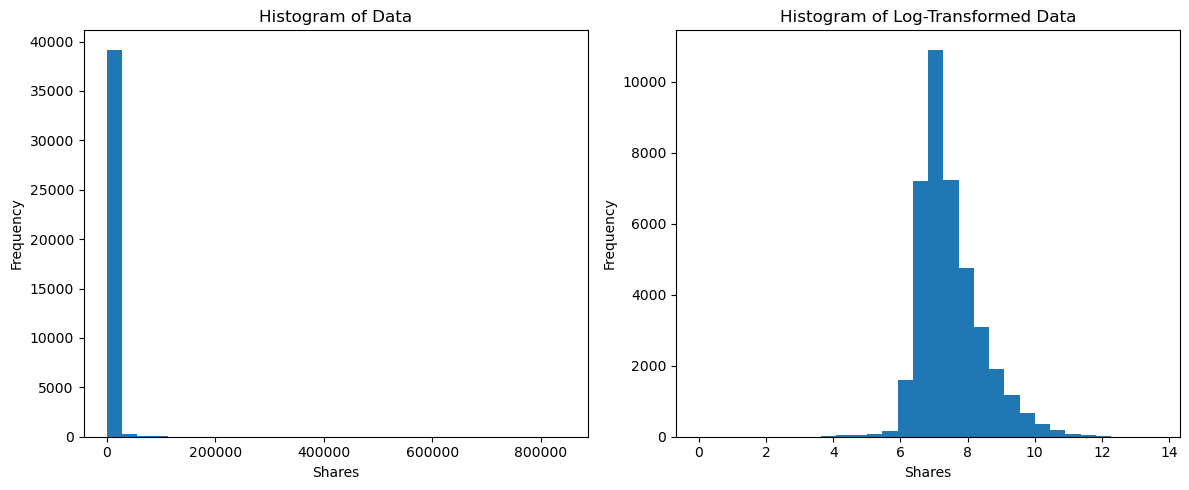

In [11]:
''' Plot target variable '''
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot original data histogram
axs[0].hist(y, bins=30)
axs[0].set_title('Histogram of Data')
axs[0].set_xlabel('Shares')
axs[0].set_ylabel('Frequency')

# Plot log-transformed data histogram
axs[1].hist(np.log(y), bins=30)
axs[1].set_title('Histogram of Log-Transformed Data')
axs[1].set_xlabel('Shares')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
''' List the statistically significant variables from linear regression '''
# Call function that drops the insignificant variables
linear_regressor_significant, X_significant = dropInsignificant(X_with_const, y)

In [28]:
X_significant.columns

Index(['const', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'num_hrefs', 'num_self_hrefs',
       'average_token_length', 'data_channel_is_entertainment',
       'data_channel_is_world', 'kw_min_min', 'kw_min_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'LDA_03', 'global_subjectivity', 'global_rate_positive_words',
       'min_positive_polarity', 'avg_negative_polarity'],
      dtype='object')

In [14]:
''' List the importance of the variables from a regression tree '''
# Fit tree
regressor = DecisionTreeRegressor()
regressor.fit(X, y)

# Get feature importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [29]:
# Display top feature importances
num_important_features = 20
most_important = importance_df.iloc[:num_important_features]
most_important

,Feature,Importance
23,kw_min_avg,0.131913
28,self_reference_avg_sharess,0.103356
39,LDA_02,0.089723
37,LDA_00,0.087034
9,average_token_length,0.080030
25,kw_avg_avg,0.064194
38,LDA_01,0.035837
24,kw_max_avg,0.028559
45,global_rate_negative_words,0.027028
44,global_rate_positive_words,0.024142


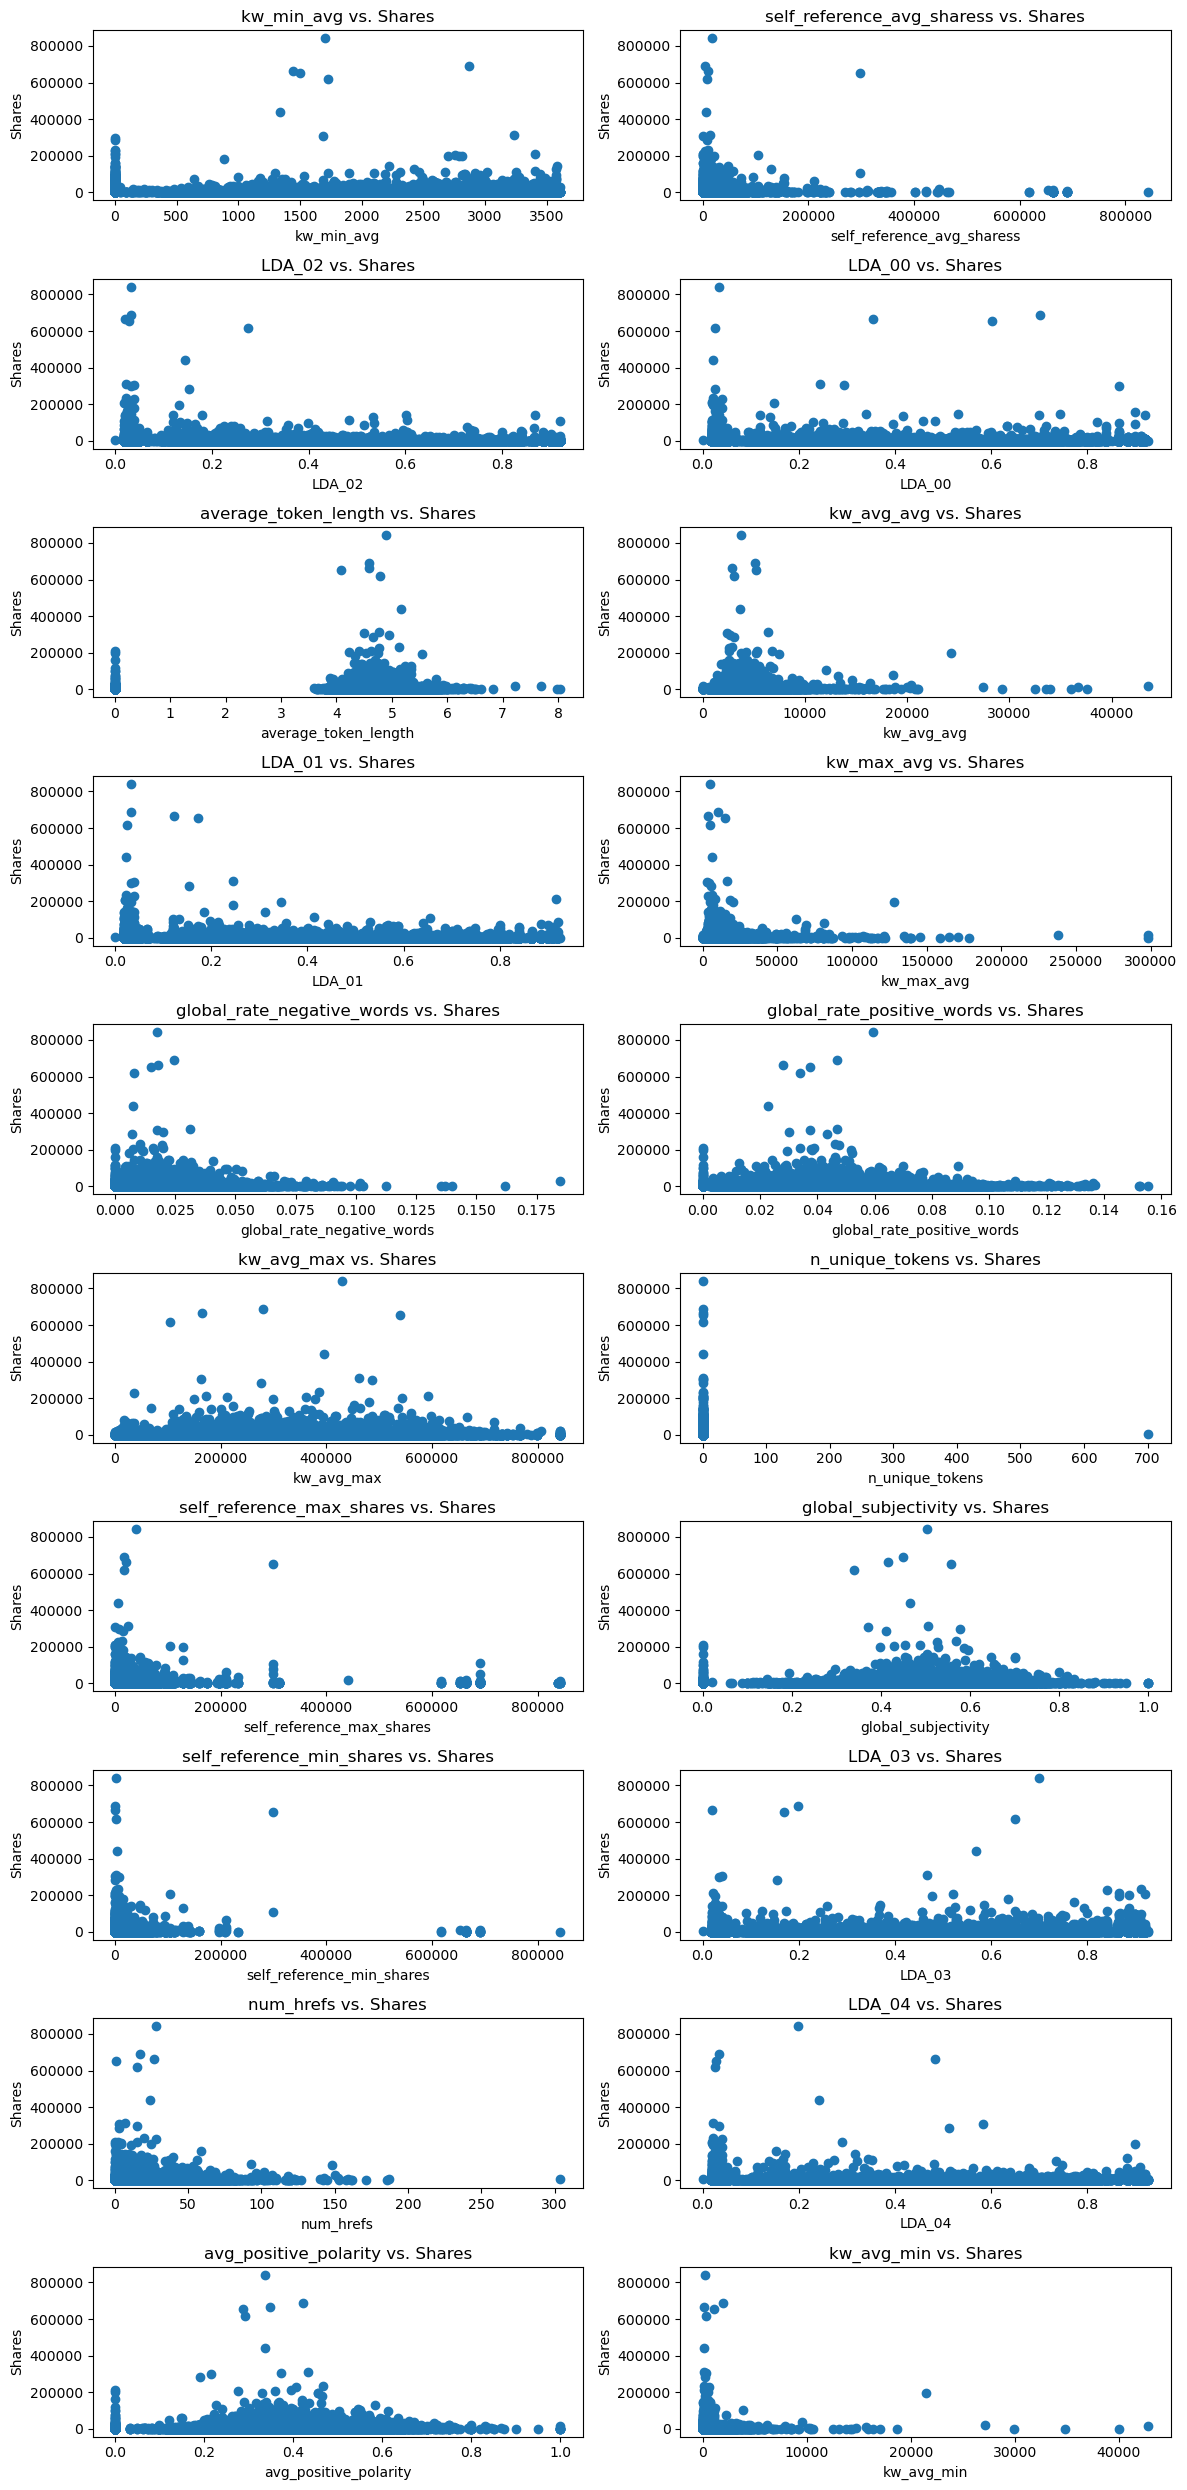

In [23]:
# Plot relationships between the most influential predictors and the target
fig, axs = plt.subplots(int(num_important_features/2), 2, figsize=(12, 25))
predictors = list(importance_df.iloc[0:num_important_features, 0])
plotRelationships(axs, X, predictors, y)

plt.tight_layout()
plt.show()

In [31]:
significant_columns = X_significant.columns
important_columns = list(most_important.iloc[:, 0])
combined_columns = []
for col in significant_columns:
    if col in important_columns:
        combined_columns.append(col)

X_final = X[combined_columns]
X_final

,n_unique_tokens,num_hrefs,average_token_length,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,LDA_03,global_subjectivity,global_rate_positive_words
0,0.663594,4.0,4.680365,0.000000,0.000000,0.000000,496.0,496.0,0.041263,0.521617,0.045662
1,0.604743,3.0,4.913725,0.000000,0.000000,0.000000,0.0,0.0,0.050101,0.341246,0.043137
2,0.575130,3.0,4.393365,0.000000,0.000000,0.000000,918.0,918.0,0.033334,0.702222,0.056872
3,0.503788,9.0,4.404896,0.000000,0.000000,0.000000,0.0,0.0,0.028905,0.429850,0.041431
4,0.415646,19.0,4.682836,0.000000,0.000000,0.000000,545.0,16000.0,0.028572,0.513502,0.074627
...,...,...,...,...,...,...,...,...,...,...,...
39639,0.529052,9.0,4.523121,2514.742857,4004.342857,3031.115764,11400.0,48000.0,0.025000,0.482679,0.037572
39640,0.696296,9.0,4.405488,1664.267857,5470.168651,3411.660830,2100.0,2100.0,0.681635,0.564374,0.039634
39641,0.516355,24.0,5.076923,1753.882353,6880.687034,4206.439195,1400.0,1400.0,0.643794,0.510296,0.033937
39642,0.539493,10.0,4.975073,0.000000,3384.316871,1777.895883,452.0,452.0,0.040002,0.358578,0.020528


#### EDA (to be added to the report)


In [17]:
# I have questions on part 6 of EDA

# Linear Regression Modeling

### Splitting the Data into Training and Testing Sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


### Exploring Transformations of the Target and Other Variables

In [33]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [34]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=[object]).columns

print(numeric_cols)
print(categorical_cols)

Index(['n_unique_tokens', 'num_hrefs', 'average_token_length', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'LDA_03', 'global_subjectivity',
       'global_rate_positive_words'],
      dtype='object')
Index([], dtype='object')


### Exploring Higher-Order Terms

In [36]:
# Continuous columns
continuous_cols = ['n_unique_tokens', 'num_hrefs', 'average_token_length', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'LDA_03', 'global_subjectivity',
       'global_rate_positive_words']

# Categorical columns
categorical_cols = []

X_train_continuous = X_train[continuous_cols]
X_test_continuous = X_test[continuous_cols]

X_train_categorical = X_train[categorical_cols]
X_test_categorical = X_test[categorical_cols]


poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_continuous_poly = poly.fit_transform(X_train_continuous)
hot_names = poly.get_feature_names_out(continuous_cols)
X_cont_poly = pd.DataFrame(X_train_continuous_poly,columns = hot_names)
# X_categorical_dummies = pd.get_dummies(X_train_categorical, drop_first=True)
# X_full = pd.concat([X_cont_poly,X_categorical_dummies],axis = 1)

poly_test = PolynomialFeatures(degree=2, include_bias=False)
X_test_continuous_poly = poly_test.fit_transform(X_test_continuous)
X_cont_poly_test = pd.DataFrame(X_test_continuous_poly,columns = hot_names)
# X_categorical_dummies_test = pd.get_dummies(X_test_categorical, drop_first=True)
# X_test_full = pd.concat([X_cont_poly_test,X_categorical_dummies_test],axis = 1)


In [37]:
for continuous_col in continuous_cols:
    for continuous_col2 in continuous_cols:
        if continuous_col != continuous_col2:  # To avoid creating duplicate interaction terms
            interaction_term_name = f"{continuous_col}_x_{continuous_col2}"
            X_cont_poly[interaction_term_name] = X_cont_poly[continuous_col] * X_cont_poly[continuous_col2]
            X_cont_poly_test[interaction_term_name] = X_cont_poly_test[continuous_col] * X_cont_poly_test[continuous_col2]

In [38]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score

imputer = SimpleImputer(strategy='mean')
X_full_imputed = imputer.fit_transform(X_cont_poly)
X_test_full_imputed = imputer.transform(X_cont_poly_test)

X_train_imputed = X_full_imputed[:len(X_train)]
X_test_imputed = X_test_full_imputed[:len(X_test)]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_log.values.reshape(-1, 1))

model_best = LassoCV(cv=2)
model_best.fit(X_train_scaled, y_train_scaled)
alpha_best = model_best.alpha_

reg_lasso = Lasso(alpha=alpha_best)
reg_lasso.fit(X_train_scaled, y_train_scaled)

train_preds_lasso = reg_lasso.predict(X_train_scaled)
test_preds_lasso = reg_lasso.predict(X_test_scaled)

r2_train = r2_score(y_train_log, y_scaler.inverse_transform(train_preds_lasso.reshape(-1, 1)))
r2_test = r2_score(y_test_log, y_scaler.inverse_transform(test_preds_lasso.reshape(-1, 1)))

print("In-Sample R^2:", r2_train)
print("Out-of-Sample R^2:", r2_test)


In-Sample R^2: 0.10114534275228948
Out-of-Sample R^2: 0.09588540802973844
